In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release
#

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import time
import numpy as np
import glob
import os
import torchaudio

In [ ]:
#implementing the Downsample (2D)
def block_downsample(channel_in, channel_out, kernel_size, padding,stride):
    '''
    downsample block
    '''
    blk = nn.Sequential(nn.Conv2d(channel_in, channel_out, kernel_size=kernel_size, 
                               padding=padding, stride = stride),
                        nn.InstanceNorm2d(channel_out),
                        nn.GLU(dim=1))
    return blk

In [ ]:
# implementing the Upsample 
def block_Upsample(channel_in, channel_out, kernel_size, padding,stride):
    '''
    Upsample block
    using the pixel shuffle to enlarge our tensor
    '''
#     blk = nn.Sequential(nn.Conv2d(channel_in, channel_out, kernel_size=kernel_size, 
#                                padding=padding, stride = stride),
#                         #nn.PixelShuffle(upscale_factor=2),
#                         nn.InstanceNorm2d(num_features=channel_out, affine=True, track_running_stats=True),
#                         nn.GLU(dim=1)
#                        )
    blk = nn.Sequential( nn.ConvTranspose2d(channel_in, channel_out, kernel_size=kernel_size, stride=stride, padding=padding),
                        nn.InstanceNorm2d(num_features=channel_out, affine=True, track_running_stats=True),
                       nn.GLU(dim=1))
    return blk

In [ ]:
# implementing the 9 blocks since it removes the residual block
class res_block(nn.Module):
    '''the nine residual_block without residual'''
    def __init__(self,channel_in, channel_out, kernel_size, padding,stride, num_styles):
        super(res_block,self).__init__()
        self.conv = nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size, 
                             padding=padding, stride=stride,bias=False)
        self.cin = CIN(in_channels=channel_out, num_styles= num_styles)
        #GLU will make the channel become half
        self.glu = nn.GLU(dim=1)
    def forward(self, x, c):
        x = self.conv(x)
        x = self.cin(x, c)
        x = self.glu(x)
        return x

In [ ]:
class CIN(nn.Module):
    '''
    The conditional instance normalization 
    using matrix of gamma and beta corresponding to each style
    '''
    def __init__(self, in_channels, num_styles):
        '''initial function'''
        super(CIN, self).__init__()
        self.in_channels = in_channels
        self.num_styles = num_styles
        self.gamma = nn.Linear(num_styles*2, in_channels)
        self.beta = nn.Linear(num_styles*2, in_channels)
    def forward(self, x, c):
        '''c is the one-hot encoding '''
        c= c.to( d2l.float32)
        u = torch.mean(x, dim=2, keepdim=True)
        std = torch.sqrt(torch.mean((x-u)*(x-u), dim=2, keepdim=True))
        #对每一个channel，做归一化
        #print(c.dtype)
        gamma = self.gamma(c.to(x.device))
        #shape is W*H, C, 1
        gamma = gamma.view(-1, self.in_channels, 1)
        beta = self.beta(c.to(x.device))
        beta = beta.view(-1, self.in_channels, 1)
        o = ((x-u) / std)*gamma + beta
        return o

In [ ]:
class Generator(nn.Module):
    '''
    The generator architecture of star-GAN vc2
    '''
    def __init__(self,num_styles):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(3,9), padding=(1,4),stride=1)
        self.glu1 = nn.GLU(dim=1)
        self.down_sample1 = block_downsample(channel_in=64, channel_out=256, padding=(1,3),
                                            stride=(2,2),kernel_size=(4,8))
        self.down_sample2 = block_downsample(channel_in=128, channel_out=512, padding=(1,3),
                                            stride=(2,2),kernel_size=(4,8))
        # reshape will be done in forward function
        self.conv2 = nn.Conv1d(2304, 256, kernel_size=1, stride=1,bias=False)
        self.istNorm = nn.InstanceNorm1d(num_features=256)
        
        self.res1 = res_block(channel_in=256, channel_out=512,kernel_size=3,
                             padding=1, stride=1, num_styles=num_styles)
        self.res2 = res_block(channel_in=256, channel_out=512,kernel_size=3,
                             padding=1, stride=1, num_styles=num_styles)
        self.res3 = res_block(channel_in=256, channel_out=512,kernel_size=3,
                             padding=1, stride=1, num_styles=num_styles)
        self.res4 = res_block(channel_in=256, channel_out=512,kernel_size=3,
                             padding=1, stride=1, num_styles=num_styles)
        self.res5 = res_block(channel_in=256, channel_out=512,kernel_size=3,
                             padding=1, stride=1, num_styles=num_styles)
        self.res6 = res_block(channel_in=256, channel_out=512,kernel_size=3,
                             padding=1, stride=1, num_styles=num_styles)
        self.res7 = res_block(channel_in=256, channel_out=512,kernel_size=3,
                             padding=1, stride=1, num_styles=num_styles)
        self.res8 = res_block(channel_in=256, channel_out=512,kernel_size=3,
                             padding=1, stride=1, num_styles=num_styles)
        self.res9 = res_block(channel_in=256, channel_out=512,kernel_size=3,
                             padding=1, stride=1, num_styles=num_styles)
        self.conv3 = nn.Conv1d(256, 2304, kernel_size=1, stride=1,padding=0,bias=False)
        #reshape back to 2d will be done in forward function
        self.up_sample1 = block_Upsample(channel_in=256, channel_out=256, kernel_size=(4,4),
                                       padding=1, stride=2)
        self.up_sample2 = block_Upsample(channel_in=128, channel_out=128, kernel_size=(4,4),
                                       padding=1, stride=2)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=7,stride=1, padding=3,bias=False)
        
    def forward(self,x,c1,c2):
        '''
        c1, c2 is the target/source one-hot encoding for target domain
        '''
        c = torch.cat((c1,c2), dim=1)
        width = x.shape[3]# 记录开始的宽
        x = self.conv1(x)
        x = self.glu1(x)
        x = self.down_sample1(x)
        x = self.down_sample2(x)
        #reshape
        #use continguous to make sure that our tensor are contiguous in the 
        # following memory, 详情见链接
        #print(x.shape)
        #shape is batch*height, channel =2304, width
        x = x.contiguous().view(-1, 2304, width//4)
        x = self.conv2(x)
        x = self.istNorm(x)
        # for 9 block without residual
        x = self.res1(x,c)
        x = self.res2(x,c)
        x = self.res3(x,c)
        x = self.res4(x,c)
        x = self.res5(x,c)
        x = self.res6(x,c)
        x = self.res7(x,c)
        x = self.res8(x,c)
        x = self.res9(x,c)
        # reshape back
        x = self.conv3(x)
        x = x.view(-1, 256, 9, width//4)
        # upsample
        x = self.up_sample1(x)
        x = self.up_sample2(x)
        # final output 
        x = self.conv4(x)
        return x

In [ ]:
class Dataset(torch.utils.data.Dataset):
    '''
    The dataset for MCEP features and speaker labels
    '''
    #we need to implement the init, len and get item function
    def __init__(self, params):
        """
        params is a class of hyper-params
        """
        self.params = params
        self.spk_list = params.spk_using
        self.feas_all, self.lab_all = self.load_all()
        self.n_files = len(self.feas_all)
        
        #get the num of speaker
        self.n_spk = len(self.spk_list)
        
        # create dict 
        self.spk2index={}
        self.index2spk={}
        self.spk2onehot={}
        temp = torch.eye(self.n_spk)
        for i, spk in enumerate(self.spk_list):
            self.spk2index[spk] = i
            self.index2spk[i] = spk
            self.spk2onehot[spk] = temp[i]
        self.pairs = []
        self.gen_random_pair()
    def gen_random_pair(self):
        idx = [i for i in range(self.n_files)]
        #print(len(idx))
        np.random.shuffle(idx)
        self.pairs = []
        for i in idx:
            fea_src =self.feas_all[i]
            spk_src = self.lab_all[i]
            #print((spk_src))
            #remove spk_src, and choose any speaker
            self.spk_list.remove(spk_src)
            spk_trg = np.random.choice(self.spk_list)
            self.spk_list.append(spk_src)
            
            # random choose the features
            idx_spk_trg = np.where(np.array(self.lab_all)==spk_trg)[0].tolist()
            idx_cs_trg =np.random.choice(idx_spk_trg)
            feature_trg = self.feas_all[idx_cs_trg]
            
            self.pairs.append(tuple([fea_src, spk_src, feature_trg, spk_trg]))
    def load_all(self):
        feas_all = []
        labs_all = []
        min_length = 256
        for speaker in self.spk_list:
            #对每一个人
            file_path = os.path.join(self.params.data_catch, speaker, 'data.npy')
            features = np.load(file_path, allow_pickle=True).tolist()
            fea = []
           # print(len(features))
            for i in features:
                if i.shape[0]>=min_length:
                    fea.append(i)
            features = fea
            #print(len(features))
            #记录labels
            labels = [speaker] * len(features)
            feas_all+=features
            labs_all+=labels
        return feas_all, labs_all
    def sample_segement(self, features, length = 256):
        assert features.shape[0] - length >= 0
        s = np.random.randint(0, features.shape[0] - length + 1)
        return features[s:s + length, :]
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        fea_a, label_a, fea_b, label_b = self.pairs[idx]
        fea_a = self.sample_segement(fea_a)
#         print(fea_b.shape)
        fea_b = self.sample_segement(fea_b)
        len_a = np.shape(fea_a)[0]
#         len_a = int(len_a//4*4)
#         fea_a = fea_a[:len_a]
        fea_a = torch.from_numpy(fea_a.T)
        fea_a = fea_a.unsqueeze(0)
        
        len_b = np.shape(fea_b)[0]
#         len_b = int(len_b//4*4)
#         fea_b = fea_b[:len_b]
        fea_b = torch.from_numpy(fea_b.T)
        fea_b = fea_b.unsqueeze(0)
        return fea_a, self.spk2onehot[label_a], self.spk2index[label_a], \
               fea_b, self.spk2onehot[label_b], self.spk2index[label_b]

In [ ]:
class hparams():
    def __init__(self):
        self.spk_using = ['VCC2SM1', 'VCC2SM2', 'VCC2SF1', 'VCC2SF2']
        self.data_catch = "../input/voiceconversion/data_catch"
        self.n_spk = 4
        
def get_dataloader (bs = 32, is_train=True):
    para = hparams()
    vc_dst = Dataset(para)
    vc_dst.load_all()
    data_loader = torch.utils.data.DataLoader(vc_dst, batch_size=bs, shuffle = is_train)
    return data_loader

In [ ]:
para = hparams()
vc_dst = Dataset(para)
vc_dst.gen_random_pair()

In [ ]:
train_iter = get_dataloader()

In [ ]:
a,b,c,d,e,f=next(iter(train_iter))

In [ ]:
class Discriminator(nn.Module):
    '''
    The discriminator module
    
    '''
    def __init__(self, num_styles):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(3,9), stride=1, padding=(1,4))
        self.glu1 = nn.GLU(dim=1)
        self.down_sample1 = block_downsample(channel_in=64, channel_out=256,
                                            kernel_size=3, padding=1, stride=2)
        self.down_sample2 = block_downsample(channel_in=128, channel_out=512,
                                            kernel_size=3, padding=1, stride=2)
        self.down_sample3 = block_downsample(channel_in=256, channel_out=1024,
                                            kernel_size=3, padding=1, stride=2)
        self.down_sample4 = block_downsample(channel_in=512, channel_out=1024,
                                            kernel_size=(1,5), padding=(0,2), stride=1)
        # linear layer
        self.fn = nn.Linear(512,1)
        self.projection = nn.Linear(2*num_styles, 512)
    def forward(self, x, c, c_):
        '''
        c and c_ are domain code
        '''
        #concat c and c_
        c_onehot = torch.cat((c,c_), dim=1).to(x.device)
        x = self.conv1(x)
        x = self.glu1(x)
        x = self.down_sample1(x)
        x = self.down_sample2(x)
        x = self.down_sample3(x)
        x_ = self.down_sample4(x)
        
        # do the global pooling
        total = torch.sum(x_, dim=(2,3))
        # do the inner product
        # use linear layer to reduce the shape of channel
        x = self.fn(total)# let it become bs,height,width, channels
        c_code = self.projection(c_onehot)
        inner_product = c_code*total
        x+=torch.sum(inner_product, dim=1, keepdim=True)
        #reshape to 2 dim: batch, channel*height*width
#         x = x.view(x.shape[0], -1)
#         x = torch.mean(x, dim=-1)+ torch.mean(inner_product, dim=-1)
        #print(x.shape, inner_product.shape)
        return x

In [ ]:
d = Discriminator(4)
d(a.float(),b,e)

# Training function
What we need?
1. Adversiral loss function
2. classification loss
3. cycle consistency loss
4. identityloss function
5. WGAN idea, change classifier to regression

## FOR discriminator
Minimize the adversiral loss
## FOR generator
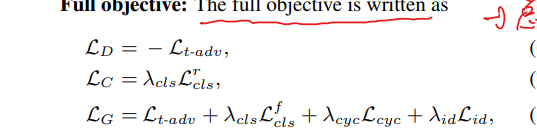

In [ ]:
def gradient_penalty(y, x,device):
        """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
        weight = torch.ones(y.size()).to(device)
        dydx = torch.autograd.grad(outputs=y,
                                   inputs=x,
                                   grad_outputs=weight,
                                   retain_graph=True,
                                   create_graph=True,
                                   only_inputs=True)[0]

        dydx = dydx.view(dydx.size(0), -1)
        dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
        return torch.mean((dydx_l2norm-1)**2)

In [ ]:
def update_lr(g_lr, d_lr, g_optimizer, d_optimizer):
        """Decay learning rates of the generator and discriminator."""
        for param_group in g_optimizer.param_groups:
            param_group['lr'] = g_lr
        for param_group in d_optimizer.param_groups:
            param_group['lr'] = d_lr

# IF YOU WANT TO TRAINING THE MODEL BY YOUR OWN, JUST REMOVE THE COMMENT ON THE next cell for net.apply()

In [ ]:
n=5
def train(net, train_iter, test_iter, lr ,num_epoches, device):
    """用GPU训练模型
    net is (discriminator, generator)
    train_iter is the total training set
    num_epoch is the total running times
    device is gpu or cpu
    """
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight.float())#初始化
    print('training on', device)#确保移到gpu
    data_iter = iter(train_iter)
    net_d = net[0]
    net_g = net[1]
    net_d.to(device)#迁移
    net_g.to(device)
#     net_d.apply(init_weights)#将其应用在每层网络
#     net_g.apply(init_weights)
    optimizer_g = torch.optim.Adam(net_g.parameters(), lr, [0.5,0.999])
    optimizer_d = torch.optim.Adam(net_d.parameters(), lr,[0.5,0.999])
    #定义lambda，作为g_loss的权重系数
    lambda_cyc = 50
    lambda_id = 50
    lambda_gp = 10
    num_iters_decay = 100000
    lr_update_step = 1000
    #start trainining 
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epoches],
                            legend=['dis_loss', 'gen_loss'])
    print('Start training....')
    start_time = time.time()
    num_batches = len(train_iter)
    for epoch in range(num_epoches):
        metric = d2l.Accumulator(3)# discriminator and generator loss
        net_d.train()
        net_g.train()
        try:
            j = next(data_iter)
        except:
            data_iter = iter(train_iter)
            j = next(data_iter)
        spk_src = j[0].to(device).to(d2l.float32)
        spk_src_onehot = j[1].to(device).to(d2l.float32)
        spk_src_label = j[2].to(device)
#             spk_trg = j[3].to(device).to(d2l.float32)
        spk_trg_onehot = j[4].to(device).to(d2l.float32)
        spk_trg_label = j[5].to(device)
        #训练Discriminator
        # 通过WGAN 思想将分类改为最小化距离
        #print(spk_src.dtype, spk_src_onehot.dtype, spk_src_label.dtype)
        d_out = net_d(spk_src,spk_src_onehot,spk_trg_onehot)
        d_loss = -torch.mean(d_out)      


        # 计算loss with fake mc feats
        fake_trg = net_g(spk_src,spk_src_onehot,spk_trg_onehot)

        d_out_fake = net_d(fake_trg.detach(), spk_src_onehot, spk_trg_onehot)
        d_loss_fake = torch.mean(d_out_fake)#MSE, 0 is the real label

        #compute loss of gradient penalty
        alpha = torch.rand(spk_src.size(0), 1, 1, 1).to(device)
        x_hat = (alpha * spk_src.data + (1-alpha) * fake_trg.data).requires_grad_(True)
        out_src = net_d(x_hat, spk_src_onehot, spk_trg_onehot)
        d_loss_gp = gradient_penalty(out_src,x_hat,device)
        #sum
        d_loss_total = d_loss+d_loss_fake+lambda_gp*d_loss_gp
        #反向传播
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()
        d_loss_total.backward()
        optimizer_d.step()
        #Train the generator
        # 三个loss，对抗性随时，分类损失（改为了wgan）,循环一致性损失，mappingloss
        #更新完discriminator后，生成新的样本, 原始域 to 目标域
        #print(i)
        if (epoch+1)%5 ==0:
            fake_trg = net_g(spk_src, spk_src_onehot, spk_trg_onehot)
            g_out = net_d(fake_trg, spk_src_onehot, spk_trg_onehot)
            g_loss_fake = -torch.mean(g_out)

        # 目标域 to 原始域， cycle consistency

            mc_cycle = net_g(fake_trg, spk_trg_onehot,spk_src_onehot)
            # L1 norm
            g_loss_cyc = torch.mean(torch.abs(spk_src - mc_cycle))

            # original - original, idmapping loss
            mc_fake_identity = net_g(spk_src, spk_src_onehot,spk_src_onehot)
            g_loss_identity = torch.mean(torch.abs(mc_fake_identity - spk_src))

            g_loss_total =lambda_cyc *g_loss_cyc + g_loss_fake + lambda_id*g_loss_identity
            optimizer_d.zero_grad()
            optimizer_g.zero_grad()
            g_loss_total.backward()
            optimizer_g.step()
            with torch.no_grad():
                metric.add(d_loss_total*spk_src.shape[0], g_loss_total*spk_src.shape[0], spk_src.shape[0])
                dis_loss = metric[0]/metric[2]
                gen_loss = metric[1]/metric[2]
                if (epoch+1)%(num_batches// 3)==0 or epoch == num_batches-1:
                    animator.add(epoch+(epoch+1)/num_batches, (dis_loss, gen_loss))
        #print out loss
        #print(epoch)
        if epoch % 100 ==0:
            dic_gen={'net':net_g.state_dict(),'optimizer':optimizer_g.state_dict(),'epoch':epoch}
            dic_dis={'net':net_d.state_dict(),'optimizer':optimizer_d.state_dict(),'epoch':epoch}
            torch.save(dic_gen,'./gen.params')
            torch.save(dic_dis, './dis.params')
        #print(num_epoches - num_iters_decay)
        if (epoch+1) % lr_update_step == 0 and (epoch+1) > (num_epoches - num_iters_decay):
            lr -= (lr / float(num_iters_decay))
            update_lr(lr, lr, optimizer_g, optimizer_d)
    #         print(1)
    print('d_loss: '+str(d_loss_total)+', g_loss'+str(g_loss_total)+'.','learning rate is:'+str(lr))

In [ ]:
lr = 0.0001
num_iters_decay = 100000
for i in range(46):
    lr -= (lr / float(num_iters_decay))
lr

# for the next training cell, notice that we provided a pretrained-model, if you want to use it, just remove the check_point and add the comment to the train method! The method converted matrix back to features will be shown in the next notebook

In [ ]:
generator = Generator(4)
dis = Discriminator(4)
# check_point_gen = torch.load("../input/starganvc2version5/gen_v7.params",map_location=torch.device('cpu'))
# check_point_dis = torch.load("../input/starganvc2version5/dis_v7.params")
# # check_point_dis, check_point_gen
# generator.load_state_dict(check_point_gen['net'])
#dis.load_state_dict(check_point_dis['net'])
net = [dis, generator]
# train(net, train_iter, None,9.994401539722842e-05, 40000, d2l.try_gpu() )
train(net, train_iter, None,1e-5, 40000, d2l.try_gpu() )

In [ ]:
SF1_data= np.load("../input/voiceconversion/data_catch/VCC2SF1/data.npy",allow_pickle=True)
test = torch.tensor(SF1_data[0]).float()
test.shape

In [ ]:
test_in = test.unsqueeze(0).unsqueeze(0)
c_src = torch.tensor([[0., 0., 1., 0.]]).float()
c_trg = torch.tensor([[1.,0.,0.,0.]]).float()

In [ ]:
test_=test_in.transpose(2,3)
result = generator(test_.float(), c_src, c_trg)

In [ ]:
out_=result.squeeze(0).squeeze(0).T.detach().numpy()
out_